# Ranking Ads (Multi-Armed Bandit)

### Métodos Analíticos 2018

#### Daniel Camarena - 109417
#### Maximiliano Alvarez - 131005

### Introducción

Un problema muy estudiado dentro de la teoría de probabilidad es aquel en el que se tiene un número fijo de recursos que deben ser asignados a diferentes opciones a elegir con el fin de maximizar una ganancia. Dentro de este problema no se tiene mayor información sobre las propiedades de las diferentes opciones (cuál generará una ganancia mayor, por ejemplo); sin embargo con el paso del tiempo y con la inversión de recursos en las diferentes opciones podemos obtener mayor información acerca de estas.

El problema de bandidos multibrazo modela a un agente que intenta simultáneamente adquirir conicimiento sobre las diferentes opciones disponibles (exploración) y optimizar sus decisiones basadas en el conocimiento adquirido con el fin de poder optimizar sus recompensas (explotación).

Dentro del problema de bandidos hay diferentes estrategias (políticas) que se pueden seguir para resolver el problema de optimización, a continuación se detallan algunas:

#### Estrategias Semi-uniformes

Las estrategias semi-uniformes fueron las primeras y más simples descubiertas para resolver el problema de los bandidos. Todas estrategias tienen un comportamiento codicioso, donde se explota la mejor opción (basado en el conocimiento adquirido) la mayor parte del tiempo excepto con una probabilidad $\epsilon$, donde se exploran otras opciones.

+ **$\epsilon$-codiciosa**: La mejor opción es explotada una porción 1 - $\epsilon$ de los intentos y se exploran nuevas opciones una porción $\epsilon$ de las veces. Un valor típico es $\epsilon$ = 1 sin embargo puede variar dependiendo del problema que se intente resolver.

+ **$\epsilon$-decreciente**: Similar al **$\epsilon$-codicioso** sin embargo, en este caso la $\epsilon$ decrece conforme el experimento avanza, esto resulta en una fase altamente explorativa al principio del experimento y altamente explotativa hacia el final.

### Objetivo

En este proyecto aplicaremos distintas políticas dentro del algoritmo *multi-armed bandit* para elegir el mejor anuncio a mostrar dentro de una página web, partiendo de un pool de anuncios, donde únicamente contaremos con la información histórica (número de clicks) de cada uno de los anuncios. 

El objetivo de cada una de las políticas implementadas será mostrar el anuncio que genere el mayor número de clicks cada vez que este sea mostrado.

Compararemos el desempeño de algunas políticas implementadas dentro de los *multi-armed bandits* en diferentes situaciones, asumiendo que cada anuncio tiene una probabilidad inherente de ser seleccionado cada vez que este es mostrado (esta probabilidad no es conocida por el agente). Para ello, cambiaremos las condiciones del ambiente, comparando así el desempeño para estas distintas condiciones:

* Mismo pago vs. Pago distinto por cada click
* Pocos anuncios vs. Muchos anuncios
* Anuncios permanentes vs. Anuncios con vigencia
* Probabilidad de elección fija vs. Probabilidad de elección cambiante

### Algoritmos más comunes

#### Epsilon codiciosa

La estrategia $\epsilon$-codiciosa es la más simple y usada estrategia para resolver el problema de los tragamonedas. Esta consiste en elegir una palanca de forma aleatoria con probabilidad $\epsilon$, o con probabilidad $1-\epsilon$ elegir la palanca con la media más alta. Esta media está basada en las recompensas obtenidas hasta el momento de la decisión. Esta $\epsilon$ se encuentra en el intervalo $(0,1)$. Los métodos que implican una distinción binaria entre la explotación (codicioso) y la exploración (uniforme sobre las posibles palancas) son conocidos como métodos semi uniformes.

#### Softmax

La estrategia Softmax consisten en una elección aleatoria de una distribución Gibbs. La palanca $k$ es elegida con probabilidad $p_k=\frac{e^{\hat{\mu}_k/\tau}}{\sum_{i=1}^n e^{\hat{\mu}_i/\tau}}$ donde $\hat{\mu_i}$ es la media estimada de las recompensas de la palanca $i$ y $\tau \in \mathbb{R}^+$ es un parámetro llamado temperatura.

#### Upper Confidence Bound Algorithm

El algoritmo UCB está basado en el principio del optimismo ante la incertidumbre, lo que implica tomar decisiones como si estuviéramos en las mejores condiciones posibles. Con lo anterior queremos decir que la media que tomamos de cada uno de los brazos es tan grande como la evidencia empírica nos permita asumirla. 

Lo anterior se basa en lo siguiente: ya sea que el optimismo esté justificado, en cuyo caso se está actuando de forma óptima, o puede ser también que el optimismo sea equivocado. En este caso, aunque el tomador de decisiones esperara una recompensa grande, este no la recibirá; después de que esto suceda un número suficiente de ocasiones, el tomador de decisiones conocerá el verdadero pago de esta opcion y terminará por cambiarla. 

#### Muestreo Thompson

El muestreo Thompson, también conocido como muestreo posterior, fue propuesto en 1933 para asignar esfuerzos experimentales en un problema de tragamonedas de dos brazos derivado de pruebas clínicas.
La idea del muestreo de Thompson es seleccionar de forma aleatoria cada brazo de acuerdo a su probabilidad de ser óptimo. 

#### a. Epsilon codiciosa

A continuación, presentaremos la implementación del algoritmo $\epsilon$-codicioso y su desempeño con diferentes $\epsilon$ **(0.1, 0.2, 0.3, 0.4, 0.5)** en un ambiente simulado de máquinas Bernoulli.

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(os.path.abspath("../"))

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

class EpsilonGreedy:
    def __init__(self, epsilon, counts=None, values=None):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms,dtype=int)
        self.values = np.zeros(n_arms,dtype=float)

    def select_arm(self):
        z = np.random.random()
        if z > self.epsilon:
            return np.argmax(self.values)
        return np.random.randint(0, len(self.values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = value * ((n-1)/n) + reward/n
        self.values[chosen_arm]=new_value

class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def draw(self):
        z = np.random.random()
        if z > self.p:
            return 0.0
        return 1.0

def test_algorithm(algo, arms, num_simulations, horizon):
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))
    for sim in range(num_simulations):
        algo.initialize(len(arms))

        for t in range(horizon):
            chosen_arm = algo.select_arm()
            chosen_arms[sim,t] = chosen_arm

            reward = arms[chosen_arm].draw()
            rewards[sim,t] = reward

            algo.update(chosen_arm, reward)

    average_rewards = np.mean(rewards, axis = 0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards

ALGORITHMS = {
    "epsilon-Greedy": EpsilonGreedy
}

def plot_algorithm(alg_name="epsilon-Greedy", arms=None, best_arm_index=None,hyper_params=None, num_simulations=1000, horizon=100, label=None,fig_size=(18, 6)):
    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    for hyper_param in hyper_params:
        algo = ALGORITHMS[alg_name](hyper_param)
        chosen_arms, average_rewards, cum_rewards = test_algorithm(algo, arms, num_simulations, horizon)
        average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(axis=0) / num_simulations
        axes[0].plot(average_probs, label=label + "= %s" %hyper_param)
        axes[0].set_xlabel("Time", fontsize=14)
        axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=14)
        axes[0].set_title("Accuray of %s"%alg_name, y=1.05, fontsize=16)
        axes[0].legend()
        axes[0].set_ylim([0, 1.05])
        axes[1].plot(average_rewards, label=label + "= %s" %hyper_param)
        axes[1].set_xlabel("Time", fontsize=14)
        axes[1].set_ylabel("Average Reward", fontsize=14)
        axes[1].set_title("Avg. Rewards of %s"%alg_name, y=1.05, fontsize=16)
        axes[1].legend()
        axes[1].set_ylim([0, 1.0])
        axes[2].plot(cum_rewards, label=label + "= %s" %hyper_param)
        axes[2].set_xlabel("Time", fontsize=14)
        axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
        axes[2].set_title("Cumulative Rewards of %s"%alg_name, y=1.05, fontsize=16)
        axes[2].legend(loc="lower right")
        plt.tight_layout()

np.random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
np.random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm_index = np.argmax(means)
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5]
plot_algorithm(alg_name="epsilon-Greedy", arms=arms, best_arm_index=best_arm_index,
               hyper_params=epsilon, num_simulations=1000, horizon=100, label="eps")


ModuleNotFoundError: No module named 'seaborn'

#### b. Epsilon codicioso decreciente

A continuación presentaremos la implementación del algoritmo $\epsilon$ codicioso decreciente y su desempeño con diferentes $\epsilon$ **(0.1,0.2,0.3,0.4,0.5)** en un ambiente simulado de máquinas Bernoulli.

In [ ]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(os.path.abspath("../"))

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

class EpsilonGreedyDec:
    def __init__(self, epsilon, counts=None, values=None):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms,dtype=int)
        self.values = np.zeros(n_arms,dtype=float)

    def select_arm(self, i):        
        z = np.random.random()
        if z > self.epsilon*(0.999**i):
            return np.argmax(self.values)
        return np.random.randint(0, len(self.values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = value * ((n-1)/n) + reward/n
        self.values[chosen_arm]=new_value

class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def draw(self):
        z = np.random.random()
        if z > self.p:
            return 0.0
        return 1.0

def test_algorithm(algo, arms, num_simulations, horizon):
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))
    for sim in range(num_simulations):
        algo.initialize(len(arms))

        for t in range(horizon):
            chosen_arm = algo.select_arm(t)
            chosen_arms[sim,t] = chosen_arm

            reward = arms[chosen_arm].draw()
            rewards[sim,t] = reward

            algo.update(chosen_arm, reward)

    average_rewards = np.mean(rewards, axis = 0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards

ALGORITHMS = {
    "epsilon-Greedy-dec": EpsilonGreedyDec
}

def plot_algorithm(alg_name="epsilon-Greedy", arms=None, best_arm_index=None,hyper_params=None, num_simulations=1000, horizon=100, label=None,fig_size=(18, 6)):
    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    for hyper_param in hyper_params:
        algo = ALGORITHMS[alg_name](hyper_param)
        chosen_arms, average_rewards, cum_rewards = test_algorithm(algo, arms, num_simulations, horizon)
        average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(axis=0) / num_simulations
        axes[0].plot(average_probs, label=label + "= %s" %hyper_param)
        axes[0].set_xlabel("Time", fontsize=14)
        axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=14)
        axes[0].set_title("Accuray of %s"%alg_name, y=1.05, fontsize=16)
        axes[0].legend()
        axes[0].set_ylim([0, 1.05])
        axes[1].plot(average_rewards, label=label + "= %s" %hyper_param)
        axes[1].set_xlabel("Time", fontsize=14)
        axes[1].set_ylabel("Average Reward", fontsize=14)
        axes[1].set_title("Avg. Rewards of %s"%alg_name, y=1.05, fontsize=16)
        axes[1].legend()
        axes[1].set_ylim([0, 1.0])
        axes[2].plot(cum_rewards, label=label + "= %s" %hyper_param)
        axes[2].set_xlabel("Time", fontsize=14)
        axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
        axes[2].set_title("Cumulative Rewards of %s"%alg_name, y=1.05, fontsize=16)
        axes[2].legend(loc="lower right")
        plt.tight_layout()

np.random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
np.random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm_index = np.argmax(means)
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5]
plot_algorithm(alg_name="epsilon-Greedy-dec", arms=arms, best_arm_index=best_arm_index,
               hyper_params=epsilon, num_simulations=1000, horizon=100, label="eps")


#### c. Upper Confidence Bound Algorithm

A continuación se presenta la implementación del algoritmo UCB y su desempeño en un ambiente simulado de máquinas Bernoulli.

In [ ]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


sys.path.append(os.path.abspath("../"))

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")


class UCB:
    def __init__(self, counts=None, values=None):
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)

    def select_arm(self):
        n_arms = len(self.counts)

        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm

        ucb_values = np.zeros(n_arms)
        n = np.sum(self.counts)
        for arm in range(n_arms):
            bonus = np.sqrt((2 * np.log(n)) / self.counts[arm])
            ucb_values[arm] = self.values[arm] + bonus

        return np.argmax(ucb_values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = value * ((n - 1) / n) + reward / n
        self.values[chosen_arm] = new_value

class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def draw(self):
        z = np.random.random()
        if z > self.p:
            return 0.0
        return 1.0

def test_algorithm(algo, arms, num_simulations, horizon):
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))
    for sim in range(num_simulations):
        algo.initialize(len(arms))

        for t in range(horizon):
            chosen_arm = algo.select_arm()
            chosen_arms[sim,t] = chosen_arm

            reward = arms[chosen_arm].draw()
            rewards[sim,t] = reward

            algo.update(chosen_arm, reward)

    average_rewards = np.mean(rewards, axis = 0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards

ALGORITHMS = {
    "UCB": UCB,
}

def plot_algorithm(alg_name="epsilon-Greedy", arms=None, best_arm_index=None,hyper_params=None, num_simulations=1000, horizon=100, label=None,fig_size=(18, 6)):
    algo = ALGORITHMS[alg_name]()
    chosen_arms, average_rewards, cum_rewards = test_algorithm(algo, arms, num_simulations, horizon)
    average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(axis=0) / num_simulations

    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    axes[0].plot(average_probs)
    axes[0].set_xlabel("Time", fontsize=14)
    axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=14)
    axes[0].set_title("Accuray of %s"%alg_name, y=1.05, fontsize=16)
    axes[0].set_ylim([0, 1.05])
    axes[1].plot(average_rewards)
    axes[1].set_xlabel("Time", fontsize=14)
    axes[1].set_ylabel("Average Reward", fontsize=14)
    axes[1].set_title("Avg. Rewards of %s"%alg_name, y=1.05, fontsize=16)
    axes[1].set_ylim([0, 1.0])
    axes[2].plot(cum_rewards)
    axes[2].set_xlabel("Time", fontsize=14)
    axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
    axes[2].set_title("Cumulative Rewards of %s"%alg_name, y=1.05, fontsize=16)
    plt.tight_layout()

np.random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
np.random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm_index = np.argmax(means)
plot_algorithm(alg_name="UCB", arms=arms, best_arm_index=best_arm_index, num_simulations=1000, horizon=100)


#### d. Sampleo Thompson

A continuación se presenta la implementación del algoritmo de sampleo de Thompson y su desempeño en un ambiente simulado de máquinas Bernoulli.

In [ ]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


sys.path.append(os.path.abspath("../"))

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")


class Thompson:
    def __init__(self, wins=None, looses=None):
        self.wins = wins
        self.looses = looses

    def initialize(self, n_arms):
        self.wins = np.zeros(n_arms, dtype=int)
        self.looses = np.zeros(n_arms, dtype=float)

    def select_arm(self):
        return np.argmax(np.random.beta(self.wins+1,self.looses+1))

    def update(self, chosen_arm, reward):
        if(reward):
            self.wins[chosen_arm] += 1
        else:
            self.looses[chosen_arm] +=1

class BernoulliArm:
    def __init__(self, p):
        self.p=p
        
    def draw(self):
        return np.random.binomial(1, self.p) == 1

def test_algorithm(algo, arms, num_simulations, horizon):
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))
    for sim in range(num_simulations):
        algo.initialize(len(arms))

        for t in range(horizon):
            chosen_arm = algo.select_arm()
            chosen_arms[sim,t] = chosen_arm

            reward = arms[chosen_arm].draw()
            rewards[sim,t] = reward

            algo.update(chosen_arm, reward)

    average_rewards = np.mean(rewards, axis = 0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards

ALGORITHMS = {
    "thompson": Thompson,
}

def plot_algorithm(alg_name="epsilon-Greedy", arms=None, best_arm_index=None,hyper_params=None, num_simulations=1000, horizon=100, label=None,fig_size=(18, 6)):
    algo = ALGORITHMS[alg_name]()
    chosen_arms, average_rewards, cum_rewards = test_algorithm(algo, arms, num_simulations, horizon)
    average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(axis=0) / num_simulations

    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    axes[0].plot(average_probs)
    axes[0].set_xlabel("Time", fontsize=14)
    axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=14)
    axes[0].set_title("Accuray of %s"%alg_name, y=1.05, fontsize=16)
    axes[0].set_ylim([0, 1.05])
    axes[1].plot(average_rewards)
    axes[1].set_xlabel("Time", fontsize=14)
    axes[1].set_ylabel("Average Reward", fontsize=14)
    axes[1].set_title("Avg. Rewards of %s"%alg_name, y=1.05, fontsize=16)
    axes[1].set_ylim([0, 1.0])
    axes[2].plot(cum_rewards)
    axes[2].set_xlabel("Time", fontsize=14)
    axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
    axes[2].set_title("Cumulative Rewards of %s"%alg_name, y=1.05, fontsize=16)
    plt.tight_layout()

np.random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
np.random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm_index = np.argmax(means)
plot_algorithm(alg_name="thompson", arms=arms, best_arm_index=best_arm_index, num_simulations=1000, horizon=100)



#### c. Softmax

A continuación presentaremos la implementación del algoritmo softmax y su desempeño con diferentes temperaturas **(0.1, 0.2, 0.3, 0.4, 0.5)** en un ambiente simulado de máquinas Bernoulli.

In [ ]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append(os.path.abspath("../"))

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")


class Softmax:
    def __init__(self, temperature, counts=None, values=None):
        self.temperature = temperature
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)

    def select_arm(self):
        z = self.values / self.temperature
        probs = np.exp(z) / np.sum(np.exp(z))
        return Softmax.categorical_draw(probs)

    @staticmethod
    def categorical_draw(probs):
        preds = np.random.multinomial(1, probs, 1)
        return np.argmax(preds)

    def update(self, chosen_arm, reward):
        # Increment counts
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        # Update the expected values of chosen arm
        value = self.values[chosen_arm]
        new_value = value * ((n - 1) / n) + reward / n
        self.values[chosen_arm] = new_value

class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def draw(self):
        z = np.random.random()
        if z > self.p:
            return 0.0
        return 1.0

def test_algorithm(algo, arms, num_simulations, horizon):
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))
    for sim in range(num_simulations):
        algo.initialize(len(arms))

        for t in range(horizon):
            chosen_arm = algo.select_arm()
            chosen_arms[sim,t] = chosen_arm

            reward = arms[chosen_arm].draw()
            rewards[sim,t] = reward

            algo.update(chosen_arm, reward)

    average_rewards = np.mean(rewards, axis = 0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards

ALGORITHMS = {
    "Softmax": Softmax,
}

def plot_algorithm(alg_name="epsilon-Greedy", arms=None, best_arm_index=None,hyper_params=None, num_simulations=1000, horizon=100, label=None,fig_size=(18, 6)):
    fig, axes = plt.subplots(1, 3, figsize=fig_size)
    for hyper_param in hyper_params:
        algo = ALGORITHMS[alg_name](hyper_param)
        chosen_arms, average_rewards, cum_rewards = test_algorithm(algo, arms, num_simulations, horizon)
        average_probs = np.where(chosen_arms == best_arm_index, 1, 0).sum(axis=0) / num_simulations
        axes[0].plot(average_probs, label=label + "= %s" %hyper_param)
        axes[0].set_xlabel("Time", fontsize=14)
        axes[0].set_ylabel("Probability of Selecting Best Arm", fontsize=14)
        axes[0].set_title("Accuray of %s"%alg_name, y=1.05, fontsize=16)
        axes[0].legend()
        axes[0].set_ylim([0, 1.05])
        axes[1].plot(average_rewards, label=label + "= %s" %hyper_param)
        axes[1].set_xlabel("Time", fontsize=14)
        axes[1].set_ylabel("Average Reward", fontsize=14)
        axes[1].set_title("Avg. Rewards of %s"%alg_name, y=1.05, fontsize=16)
        axes[1].legend()
        axes[1].set_ylim([0, 1.0])
        axes[2].plot(cum_rewards, label=label + "= %s" %hyper_param)
        axes[2].set_xlabel("Time", fontsize=14)
        axes[2].set_ylabel("Cumulative Rewards of Chosen Arm", fontsize=14)
        axes[2].set_title("Cumulative Rewards of %s"%alg_name, y=1.05, fontsize=16)
        axes[2].legend(loc="lower right")
        plt.tight_layout()

np.random.seed(1)
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
np.random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
best_arm_index = np.argmax(means)
temperature = [0.1, 0.2, 0.3, 0.4, 0.5]
plot_algorithm(alg_name="Softmax", arms=arms, best_arm_index=best_arm_index,
               hyper_params=temperature, num_simulations=1000, horizon=100, label="temp")


###  Configuración clásica

Con el fin de comparar diferentes politicas, empezaremos con la formulación más común de este problema, descrita a continuación: 

+ En cada paso un anuncio tiene que ser elegido para ser mostrado dentro de un pool de anuncios.
+ Cada anuncio tiene una probabilidad de ser clickeado cuando es mostrado, esta probabilidad es constante en el tiempo.
+ Cada vez que un anuncio es mostrado, se conoce si fue clickeado o no.
+ No hay diferencia entre los clicks otorgados por el usuario, i.e. la recompensa es igual siempre.

El ambiente de simulación se configurará como sigue:

+ Probabilidad de cada anuncio para recibir un click ($P(click_{ad})\sim Beta(2,17)$).
+ 100,000 iteraciones en el tiempo.
+ Cuando aplique, la probabilidad inicial de recibir un click será del 50 por ciento.

/home/maximiliano/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp
/home/maximiliano/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/home/maximiliano/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


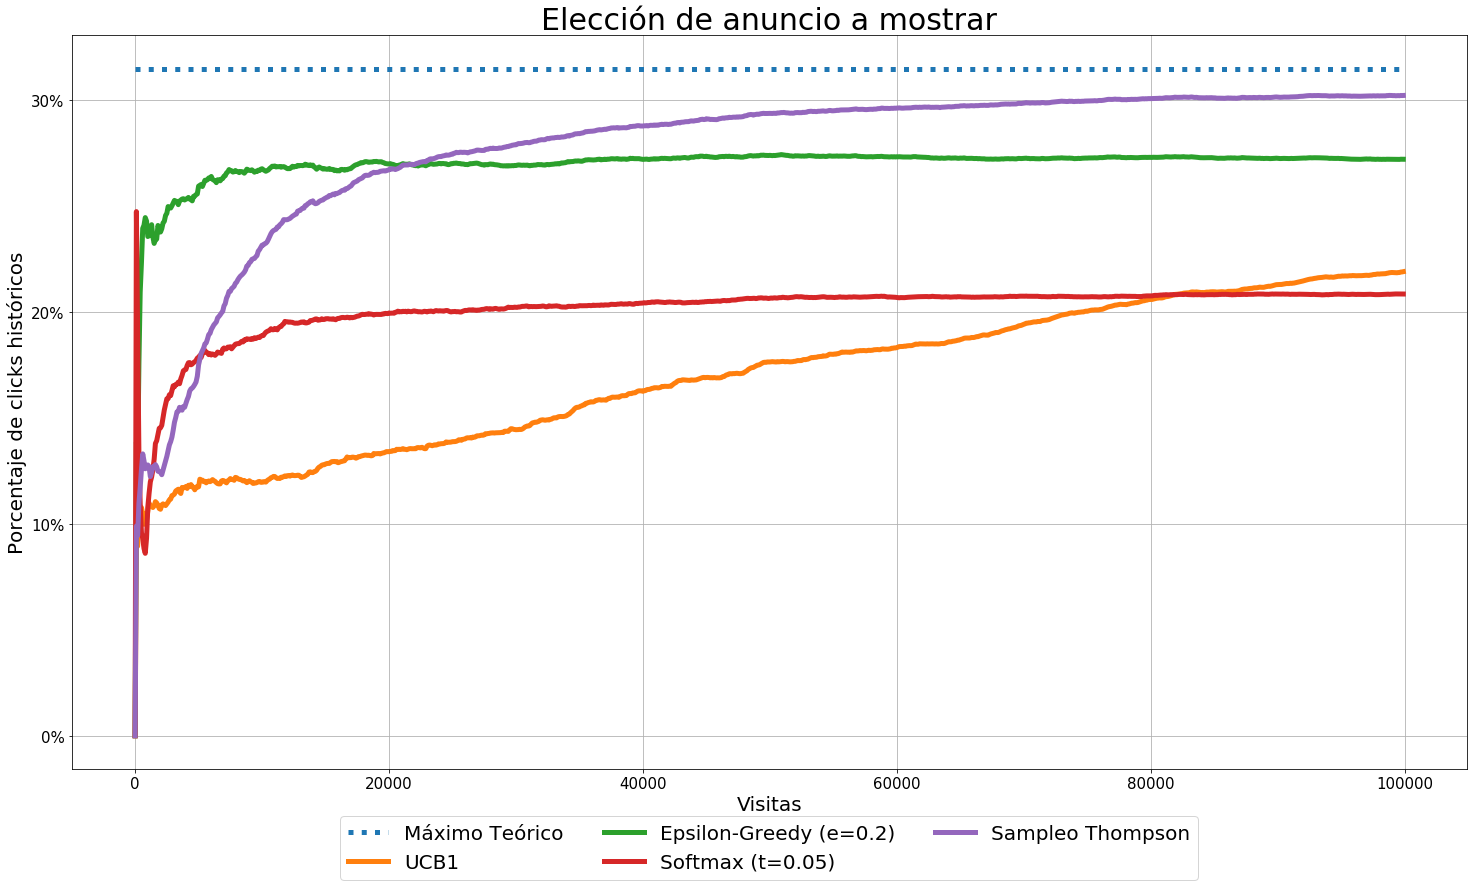

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline

# Creamos 100 anuncios
n_ads=100
np.random.seed(159)
ads_clickprob=np.random.beta(2,17,size=n_ads)
max_ctr=np.max(ads_clickprob)

# Contadores para cada algoritmo
clicks_eg1=np.array([1]*n_ads)
trials_eg1=np.array([2]*n_ads)
ctr_eg1 = list()

clicks_softmax=np.array([1]*n_ads)
trials_softmax=np.array([2]*n_ads)
ctr_softmax = list()

clicks_ucb1=np.array([1]*n_ads)
trials_ucb1=np.array([2]*n_ads)
ctr_ucb1=list()

clicks_thomp=np.array([0]*n_ads)
trials_thomp=np.array([0]*n_ads)
ctr_thomp=list()

# Iniciamos simulacion

np.random.seed(123)
for i in range(100000):
    if np.random.random()<=0.2: #Estamos considerando una epsilon de 0.2
        ad_eg1=np.random.randint(low=0,high=n_ads)
    else:
        ad_eg1=np.argmax(clicks_eg1/trials_eg1)
    trials_eg1[ad_eg1]+=1
    
    z = clicks_softmax / 0.05 #Estamos considerando una temperatura de 0.1
    probs = np.exp(z) / np.sum(np.exp(z))
    
    ad_softmax=np.argmax(np.random.multinomial(1, probs, 1))
    trials_softmax[ad_softmax]+=1
    
    ad_ucb1=np.argmax(clicks_ucb1/trials_ucb1 + np.sqrt(2*np.log(i+3))/np.sqrt(trials_ucb1))
    trials_ucb1[ad_ucb1]+=1
    
    ad_thompson=np.argmax([np.random.beta(clicks_thomp[a]+1,trials_thomp[a]-clicks_thomp[a]+1) for a in range(n_ads)])
    trials_thomp[ad_thompson]+=1
    
    # Determinando los anuncios con clicks
    would_have_clicked=[np.random.binomial(1,ads_clickprob[a]) for a in range(n_ads)]
    
    clicks_eg1[ad_eg1]+=would_have_clicked[ad_eg1]
    clicks_softmax[ad_softmax]+=would_have_clicked[ad_softmax]
    clicks_ucb1[ad_ucb1]+=would_have_clicked[ad_ucb1]
    clicks_thomp[ad_thompson]+=would_have_clicked[ad_thompson]
    
    # Revisando el CTR de cada algoritmos cada 100 iteraciones
    if (i%100)==0:
        ctr_eg1.append((np.sum(clicks_eg1)-1*n_ads)/(np.sum(trials_eg1)-2*n_ads))
        ctr_softmax.append((np.sum(clicks_softmax)-1*n_ads)/(np.sum(trials_softmax)-2*n_ads))
        ctr_ucb1.append((np.sum(clicks_ucb1)-1*n_ads)/(np.sum(trials_ucb1)-2*n_ads))
        ctr_thomp.append(np.sum(clicks_thomp)/np.sum(trials_thomp))
        

# Visualizando resultados
rcParams['figure.figsize'] = 25, 15
lwd=5
plt.plot([np.max(ads_clickprob)]*int((i+1)/100),linestyle=':',label='Máximo Teórico',linewidth=lwd)
plt.plot(ctr_ucb1,label='UCB1',linewidth=lwd)
plt.plot(ctr_eg1,label='Epsilon-Greedy (e=0.2)',linewidth=lwd)
plt.plot(ctr_softmax,label='Softmax (t=0.05)',linewidth=lwd)
plt.plot(ctr_thomp,label='Sampleo Thompson',linewidth=lwd)
plt.grid()

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})
plt.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels([0]+[100*i for i in range(0,1000+200,200)])
ax.yaxis.set_ticks([i/10 for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])
ax.yaxis.set_ticklabels([str(i*10)+'%' for i in range(0,int(10*np.round(np.max(ads_clickprob),1))+1)])

plt.xlabel('Visitas',size=20)
plt.ylabel('Porcentaje de clicks históricos',size=20)
plt.title('Elección de anuncio a mostrar',size=30)
plt.show()
    
    

#### Conclusiones sobre el ejercicio

Concluir un poco sobre las graficas presentadas anteriormente

### Diferentes precios y múltiples anuncios mostrados

Los mismos algoritmos mostrados anteriormente puedes ser de utilidad en el caso en el que tenemos diferentes precios por anuncio (diferente recompensa) y múltiples anuncios mostrados cada vez (mostrar 5 anuncios en lugar de 1), seleccionando el anuncio con el mayor limite superior esperado de recompensa, es decir, $\text{argmax } Revenue_i \text{ } UCB(\hat{P_i})$

Solamente en el caso del $\epsilon$-codicioso se pierde un poco de desempeño con respecto a UCB debido a que el primero selecciona aleatoriamente anuncios sin importar la recompensa obtenida.

El escenario de simulación es el mismo que el anterior con los siguientes cambios:

+ Se muestran 5 anuncios en cada oportunidad y la probabilidad de click en cada uno de ellos es independiente.
+ Cada anuncio tiene un precio por click diferente, simulado a partir de una distribución Gamma.

/home/maximiliano/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp
/home/maximiliano/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/home/maximiliano/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


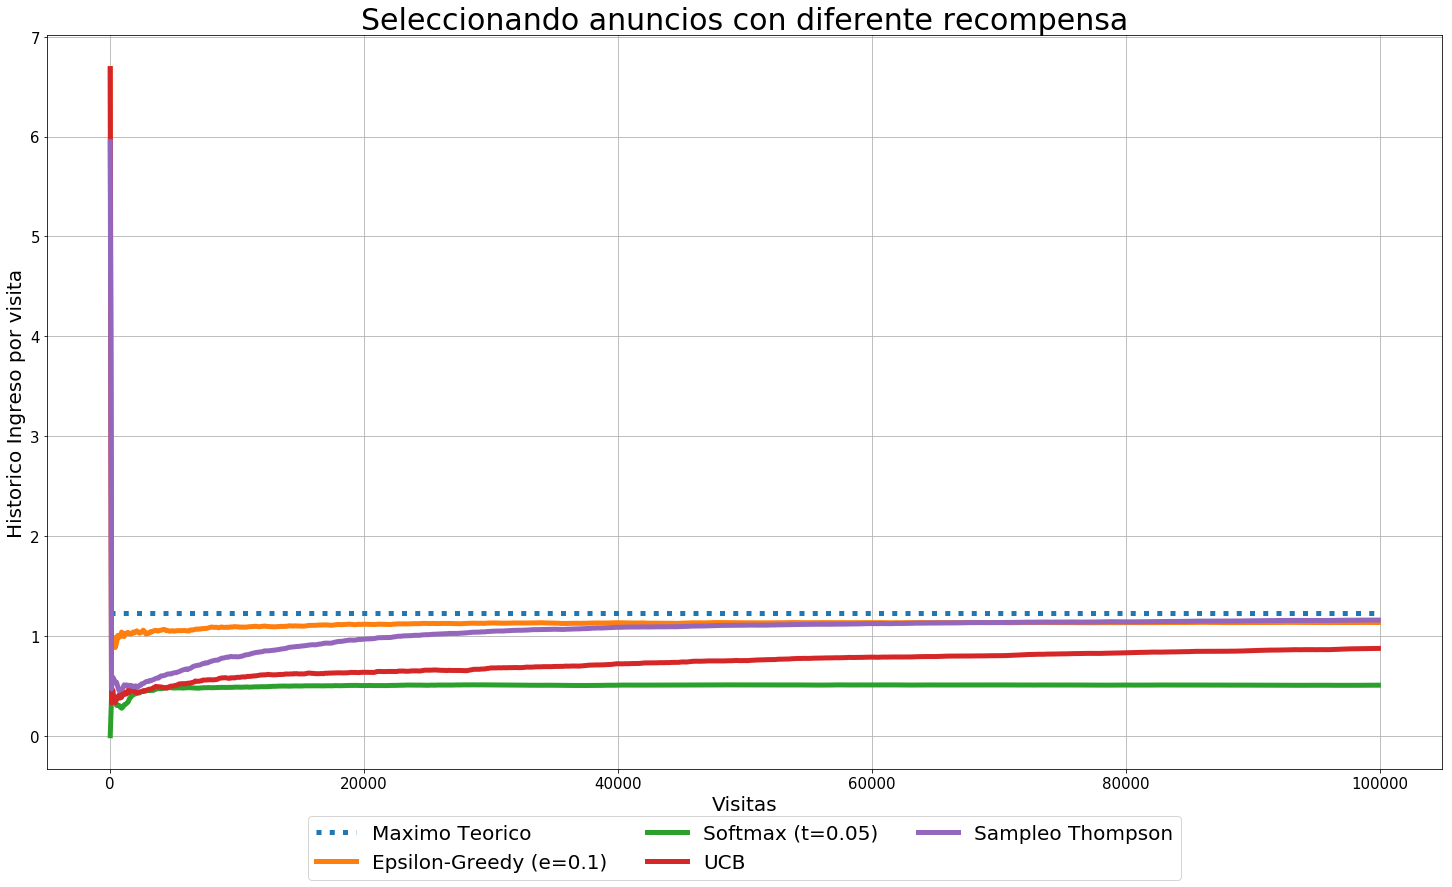

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
# mismo escenario que el anterior
# tenemos precio por cada click
n_ads=100
np.random.seed(159)
ads_clickprob=np.random.beta(2,17,size=n_ads)
ads_payment=np.random.gamma(20,.2,size=n_ads)
max_value=np.max(ads_clickprob*ads_payment)

clicks_eg1=np.array([1]*n_ads)
trials_eg1=np.array([2]*n_ads)
avg_rev_eg1=list()

clicks_softmax=np.array([1]*n_ads)
trials_softmax=np.array([2]*n_ads)
avg_rev_softmax = list()

clicks_ucb1=np.array([1]*n_ads)
trials_ucb1=np.array([2]*n_ads)
avg_rev_ucb1=list()

clicks_thomp=np.array([0]*n_ads)
trials_thomp=np.array([0]*n_ads)
avg_rev_thomp=list()

rev_eg1=0
rev_softmax=0
rev_ucb1=0
rev_thomp=0

np.random.seed(123)
for i in range(100000):
    if np.random.random()<=.1:
        ad_eg1=np.random.randint(low=0,high=n_ads)
    else:
        ad_eg1=np.argmax(ads_payment*clicks_eg1/trials_eg1)
    trials_eg1[ad_eg1]+=1
    
    z = clicks_softmax / 0.05 #Estamos considerando una temperatura de 0.1
    probs = np.exp(z) / np.sum(np.exp(z))
    
    ad_softmax=np.argmax(np.random.multinomial(1, probs, 1))
    trials_softmax[ad_softmax]+=1
    
    ad_ucb1=np.argmax(ads_payment*(clicks_ucb1/trials_ucb1 + np.sqrt(2*np.log(i+3))/np.sqrt(trials_ucb1)))
    trials_ucb1[ad_ucb1]+=1
    
    ad_thompson=np.argmax(ads_payment*np.array([np.random.beta(clicks_thomp[a]+1,trials_thomp[a]-clicks_thomp[a]+1) for a in range(n_ads)]))
    trials_thomp[ad_thompson]+=1
    
    # determining clicks
    would_have_clicked=[np.random.binomial(1,ads_clickprob[a]) for a in range(n_ads)]
    
    clicks_eg1[ad_eg1]+=would_have_clicked[ad_eg1]
    clicks_softmax[ad_softmax]+=would_have_clicked[ad_softmax]
    clicks_ucb1[ad_ucb1]+=would_have_clicked[ad_ucb1]
    clicks_thomp[ad_thompson]+=would_have_clicked[ad_thompson]
    
    rev_eg1+=would_have_clicked[ad_eg1]*ads_payment[ad_eg1]
    rev_softmax+=would_have_clicked[ad_softmax]*ads_payment[ad_softmax]
    rev_ucb1+=would_have_clicked[ad_ucb1]*ads_payment[ad_ucb1]
    rev_thomp+=would_have_clicked[ad_thompson]*ads_payment[ad_thompson]
    
    if (i%100)==0:
        avg_rev_eg1.append(rev_eg1/(i+1))
        avg_rev_softmax.append(rev_softmax/(i+1))
        avg_rev_ucb1.append(rev_ucb1/(i+1))
        avg_rev_thomp.append(rev_thomp/(i+1))
        
rcParams['figure.figsize'] = 25, 15
lwd=5
plt.plot([max_value]*int((i+1)/100),linestyle=':',label='Maximo Teorico',linewidth=lwd)
plt.plot(avg_rev_eg1,label='Epsilon-Greedy (e=0.1)',linewidth=lwd)
plt.plot(avg_rev_softmax,label='Softmax (t=0.05)',linewidth=lwd)
plt.plot(avg_rev_ucb1,label='UCB',linewidth=lwd)
plt.plot(avg_rev_thomp,label='Sampleo Thompson',linewidth=lwd)
plt.grid()

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})

plt.tick_params(axis='both', which='major', labelsize=15)
ax.xaxis.set_ticklabels([0]+[100*i for i in range(0,1000+200,200)])

plt.xlabel('Visitas',size=20)
plt.ylabel('Historico Ingreso por visita',size=20)
plt.title('Seleccionando anuncios con diferente recompensa',size=30)
plt.show()

#### Comentarios Adicionales

### Conclusiones

### Referencias

+ "Multi-Armed Bandit Algorithms and Empirical". Joann`es Vermorel and Mehryar Mohri. <https://cs.nyu.edu/~mohri/pub/bandit.pdf>
+ "A Tutorial on Thompson Sampling". Daniel J. Russo, et. al. <https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf>
+ "An Empirical Evaluation of Thompson Sampling". Olivier Chapelle, Lihong Li. <https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf>